In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [12]:
def plot_column(ax, column, df):
    if df[column].dtype == 'object':
        # Check if binary
        if df[column].nunique() == 2:
            # Binary data visualization
            df[column].value_counts().plot(kind='bar', ax=ax)
        else:
            # Categorical data visualization
            df[column].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax)
    elif df[column].dtype == 'int64' or df[column].dtype == 'float64':
        # Numeric data visualization
        df[column].plot(kind='hist', bins=20, ax=ax)
    else:
        ax.text(0.5, 0.5, f"Unhandled data type for column: {column}", 
                fontsize=12, ha='center')
    ax.set_title(column)


In [3]:
def read_files_in_directory(directory):

    file_paths = []
    for root, _, files in os.walk(directory):

        for file in files:
            if file[-3:] != "txt":
                file_path = os.path.join(root, file)
                file_paths.append(file_path)
    return file_paths
directory_path = "data/geneReadTest/"
files = read_files_in_directory(directory_path)

In [3]:
HS = ["ALDOA", "ANGPTL4" , "ANLN" , "BNC1" , 'C20orf20' , 'CA9' , 
      'CDKN3' , 'COL4A6' , 'DCBLD1' , 'ENO1' , 'FAM83B', 'FOSL1' , 
      'GNAI1' , 'HIG2' , 'KCTD11' , 'KRT17' , 'LDHA' , 'MPRS17' , 
      "P4HA1" 	, 'PGAM1' 	, 'PGK1' 	, 'SDC1' 	, 'SLC16A1' , 
      'SLC2A1', 'TPI1' 	, 'VEGFA']

IS = ["HLA-DQA1", "HLA-DQA2", "HLA-DRB5", "CTLA4", "PDCD1LG2", 
      'ICAM1', 'CD274', 'STAT1', 'IRF1', 'IFNG', 'GNLY', "TBX21", 
      "CCL5", "LAG3", "CD247", 'ICOS', 'IL18RAP', "CXCL9", "CXCL10", 
      "HLA-DPB1", 'HLA-DPA1', "HLA-DMB", 'HLA-DRA', 'HLA-DMA', 'CD80', 
      "HLA-DOA", "CD4"]
hypooxia_immue_signature = HS + IS

In [4]:
def extract_hypooxia_immue_signature(file):
    df = pd.read_csv(file, sep='\t',skiprows=1)
    filtered_df = df[df['gene_name'].isin(hypooxia_immue_signature)]
    gene_in_data = set(df['gene_name'])
    not_detected = set(hypooxia_immue_signature) - gene_in_data
    return filtered_df, not_detected

In [5]:
for file in files:
    df, not_detected = extract_hypooxia_immue_signature(file)
    print(not_detected)

{'MPRS17', 'HIG2', 'C20orf20'}
{'MPRS17', 'HIG2', 'C20orf20'}
{'MPRS17', 'HIG2', 'C20orf20'}
{'MPRS17', 'HIG2', 'C20orf20'}
{'MPRS17', 'HIG2', 'C20orf20'}
{'MPRS17', 'HIG2', 'C20orf20'}
{'MPRS17', 'HIG2', 'C20orf20'}
{'MPRS17', 'HIG2', 'C20orf20'}
{'MPRS17', 'HIG2', 'C20orf20'}


# Gene
| case_ID | gene_1 | gene_2 | .... | 
##### Case Id to be matched


In [6]:
def extract_tpm(file):
    df = pd.read_csv(file, sep='\t',skiprows=1)
    subset_df = df.iloc[4:, df.columns.isin(['tpm_unstranded', 'gene_id', 'gene_name'])]
    subset_df['header'] = subset_df['gene_id'] + '_' + subset_df['gene_name'] # Same genes, different id. multiple record
    transposed_df = subset_df[['header', 'tpm_unstranded']].T
    transposed_df.columns = transposed_df.loc['header']
    transposed_df = transposed_df.drop('header').reset_index(drop=True).sort_index(axis=1)
    return transposed_df

In [9]:
def merge_cases(files,extractor):
    merged = extractor(files[0])
    for file in files[1:]:
        to_be_merge = extractor(file)
        merged = pd.concat([to_be_merge, merged], axis=0, ignore_index=True)
    return merged
    

In [8]:
merge_gene_read = merge_cases(files,extract_tpm)


# Protein
| case_ID | protein_1 | protein_2 | .... |

In [4]:
# directory_path = "../data/Protein_Expression"
# files = read_files_in_directory(directory_path)

In [79]:
def get_case_id_from_filename(file):
    index = file.find("TCGA")
    return file[index:index+12]

In [80]:
def extract_protein_expression(file):
    df = pd.read_csv(file, sep='\t')
    subset_df = df[['protein_expression', 'AGID']]
    transposed_df = subset_df.set_index('AGID').T
    transposed_df = transposed_df.reset_index(drop=True)
    transposed_df.insert(0, 'case_submitter_id', [get_case_id_from_filename(file)])
    return transposed_df

In [81]:
merged_protein_expression = pd.read_csv('merged_protein_expression.csv')
merged_protein_expression.shape

(353, 488)

In [82]:
# merged_protein_expression = merge_cases(files,extract_protein_expression).sort_values(by='case_submitter_id')
# merged_protein_expression.to_csv('merged_protein_expression.csv',index=False)

In [83]:
def calculate_column_statistics(df):
    results = pd.DataFrame(index=df.columns, columns=['Mean', 'Variance', 'NumUniqueValues', 'NumNaNs'])
    for column in df.columns:
        if column not in ["case_submitter_id"]:
            results.at[column, 'Mean'] = df[column].mean()
            results.at[column, 'Variance'] = df[column].var()
            results.at[column, 'NumUniqueValues'] = df[column].nunique()
            results.at[column, 'NumNaNs'] = df[column].isna().sum()
    return results

In [84]:
pd.set_option('display.max_rows', 500)

In [85]:
statistics= calculate_column_statistics(merged_protein_expression)


In [93]:
def extract_rows_by_nan(df, nan_threshold=353):
    columns = [column for column in df.columns if df[column].isna().sum() == nan_threshold]
    return columns

In [87]:
statistics= calculate_column_statistics(merged_protein_expression)
statistics["NumNaNs"].unique()

array([nan, 0, 10, 353, 141, 280], dtype=object)

353 means the protein is missing in all cases, drop

In [78]:
empmpty_columns = extract_rows_by_nan(merged_protein_expression,353)
merged_protein_expression = merged_protein_expression.drop(columns=empmpty_columns)
merged_protein_expression.shape

(353, 470)

488-470 = 18: 18 protein is removed since they are empty

In [62]:
full_columns = extract_rows_by_nan(merged_protein_expression,0)
merged_protein_expression[full_columns].shape

(353, 218)

218/488 protein recorded in all 353 cases

In [98]:
def extract_rows_with_nan(df, columns):
    return df[df[columns].isnull().any(axis=1)]

In [94]:
columns_missing_10 = extract_rows_by_nan(merged_protein_expression,10)
merged_protein_expression[columns_missing_10].isna().any(axis=1).sum()

10

In [106]:
missing_rows=extract_rows_with_nan(merged_protein_expression,columns_missing_10)[["case_submitter_id"]+columns_missing_10]

Above 10 cases contains 240 missing values, too much missing and only 10, drop?

In [110]:
merged_protein_expression = merged_protein_expression.drop(missing_rows.index)
merged_protein_expression.shape

(343, 470)

In [115]:
calculate_column_statistics(merged_protein_expression)["NumNaNs"].unique()

array([nan, 0, 141, 270], dtype=object)

1 columns missing in 280 cases now 270

In [118]:
columns = extract_rows_by_nan(merged_protein_expression,270)
column = merged_protein_expression[columns]
calculate_column_statistics(column)

,Mean,Variance,NumUniqueValues,NumNaNs
AGID00332,0.753015,1.012533,73,270


In [ ]:
merged_protein_expression = merged_protein_expression.drop(["AGID00332"],axis=1)
merged_protein_expression.shape


In [124]:
calculate_column_statistics(merged_protein_expression)["NumNaNs"].unique()

array([nan, 0, 141], dtype=object)

In [131]:
columns = extract_rows_by_nan(merged_protein_expression,141)
merged_protein_expression[columns].shape


(343, 12)

12 columns 141 missing values, imputation?
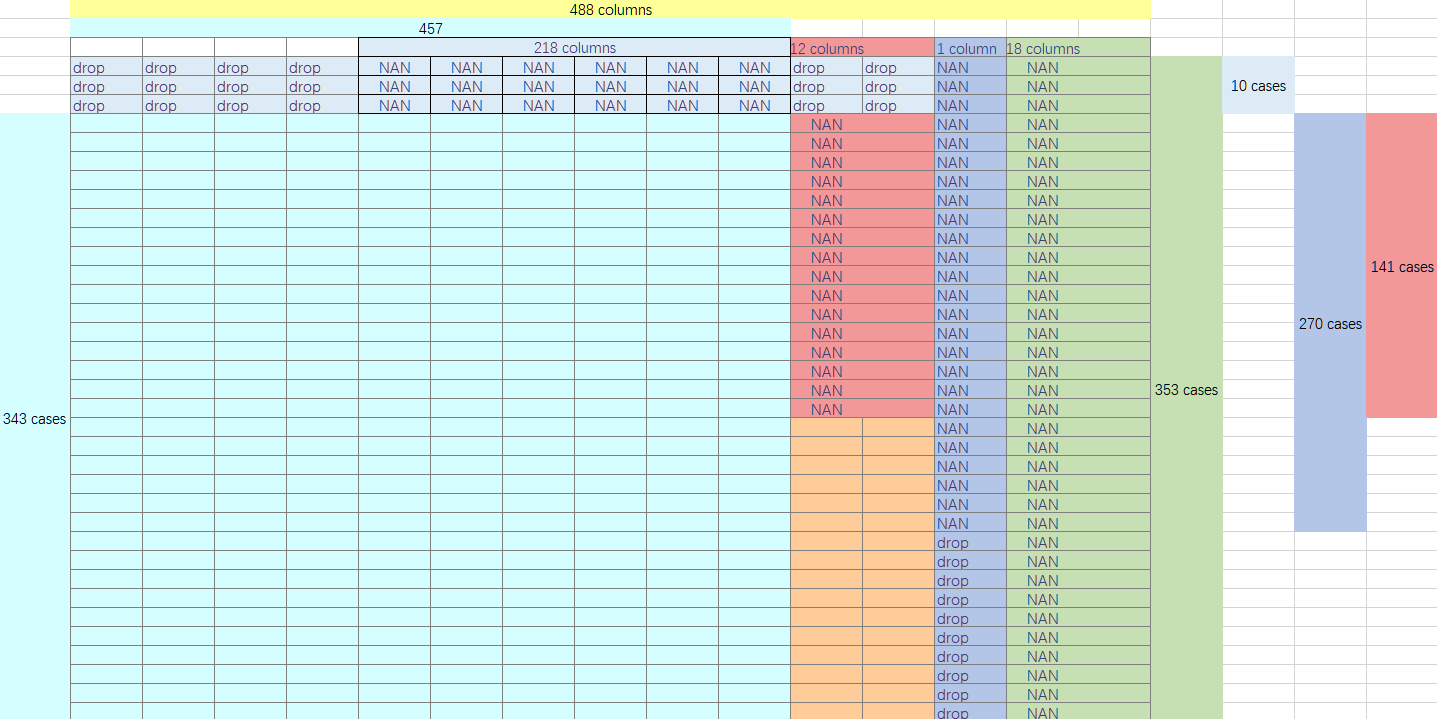

In [135]:
medians = merged_protein_expression[columns].median()

merged_protein_expression[columns] = merged_protein_expression[columns].fillna(medians)
protein_expression_no_inputation = merged_protein_expression.drop(columns=columns, axis=1)
print(merged_protein_expression.shape,protein_expression_no_inputation.shape)


(343, 469) (343, 457)


In [136]:
path = "D:\\UCL\\Week14\\HSAE\\data\\clinical\\clinical.tsv"
df = pd.read_csv(path,sep='\t')

In [137]:
df['days_to_death'] = pd.to_numeric(df['days_to_death'], errors='coerce')

In [51]:
# df['days_to_last_follow_up'] = pd.to_numeric(df['days_to_last_follow_up'], errors='coerce')
# df['days_to_death'] = pd.to_numeric(df['days_to_death'], errors='coerce')
# df['days_to_diagnosis'] = pd.to_numeric(df['days_to_diagnosis'], errors='coerce')
# deceased_patients = df[df['vital_status'] == 'Dead']


In [ ]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 30))
# fig.tight_layout(pad=5.0)


# for i, col in enumerate(merged_protein_expression):

#     plot_column(axes[i//4, i%4], col,df[["days_to_death"]])


# plt.show()

In [ ]:
colums = ["case_submitter_id","age_at_index", "days_to_birth", "days_to_death", "ethnicity", "gender", "race", "vital_status", "age_at_diagnosis", "days_to_last_follow_up","year_of_diagnosis", "treatment_or_therapy"]
deduplicate = df[df.index %2 !=0].sort_values(by='case_submitter_id')

deduplicate[colums]

In [142]:
merged_df_no_inputation = pd.merge(protein_expression_no_inputation, deduplicate[["days_to_death","case_submitter_id"]], on='case_submitter_id', how='inner')
merged_df = pd.merge(merged_protein_expression, deduplicate[["days_to_death","case_submitter_id"]], on='case_submitter_id', how='inner')
print(merged_df.shape, merged_df_no_inputation.shape)

(343, 470) (343, 458)


AE

In [143]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [144]:
merged_df = merged_df.drop('case_submitter_id', axis=1)
other = merged_df.columns.drop("days_to_death")
X_train, X_test, y_train, y_test = train_test_split(merged_df[other], merged_df["days_to_death"],
                                                    train_size=0.75,
                                                    random_state=1)

In [145]:
merged_df_no_inputation = merged_df_no_inputation.drop('case_submitter_id', axis=1)
other = merged_df_no_inputation.columns.drop("days_to_death")
X_train_no_inputation, X_test_no_inputation, y_train_no_inputation, y_test_no_inputation = train_test_split(merged_df_no_inputation[other], merged_df_no_inputation["days_to_death"],
                                                    train_size=0.75,
                                                    random_state=1)

In [153]:
y_train.describe()

count     125.000000
mean      799.008000
std      1044.466189
min         2.000000
25%       253.000000
50%       449.000000
75%       853.000000
max      6417.000000
Name: days_to_death, dtype: float64

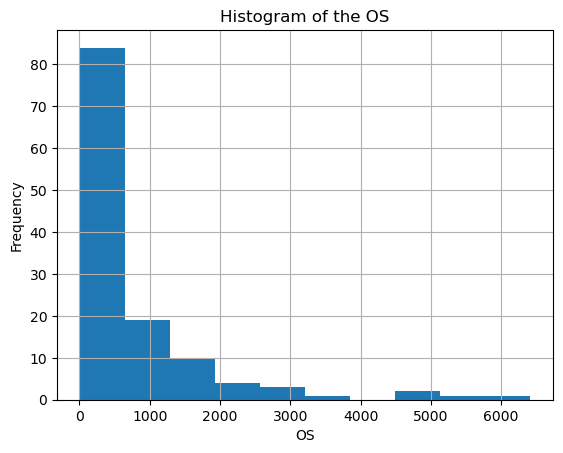

In [151]:
y_train.hist()  # Adjust the number of bins as needed
plt.xlabel('OS')
plt.ylabel('Frequency')
plt.title('Histogram of the OS')
plt.show()

survice timespan: 
1. 0-1
2. 1-3
3. 3-5
4. 5-10
5. 10-20
6. >20 /alive

In [154]:
# Number of features in your dataset
n_features = len(X_train.columns) 


input_layer = Input(shape=(n_features,))
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dense(32, activation='relu')(encoder)


bottleneck = Dense(6, activation='relu')(encoder)  

# Define the decoder (mirror the encoder)
decoder = Dense(32, activation='relu')(bottleneck)
decoder = Dense(64, activation='relu')(decoder)

# Output layer
output_layer = Dense(n_features, activation='sigmoid')(decoder) 

# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

In [156]:
history = autoencoder.fit(X_train, X_train,  # The target is the input data itself
                epochs=100,
                batch_size=16,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/100
17/17 [==============================] - 1s 73ms/step - loss: 0.2898 - val_loss: 0.2796
Epoch 2/100
17/17 [==============================] - 0s 5ms/step - loss: 0.2890 - val_loss: 0.2796
Epoch 3/100
17/17 [==============================] - 0s 5ms/step - loss: 0.2887 - val_loss: 0.2793
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.2886 - val_loss: 0.2795
Epoch 5/100
17/17 [==============================] - 0s 6ms/step - loss: 0.2886 - val_loss: 0.2795
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 0.2883 - val_loss: 0.2801
Epoch 7/100
17/17 [==============================] - 0s 5ms/step - loss: 0.2883 - val_loss: 0.2799
Epoch 8/100
17/17 [==============================] - 0s 6ms/step - loss: 0.2891 - val_loss: 0.2801
Epoch 9/100
17/17 [==============================] - 0s 5ms/step - loss: 0.2885 - val_loss: 0.2799
Epoch 10/100
17/17 [==============================] - 0s 5ms/step - loss: 0.2880 - val_loss: 0.2801
Epoch 11

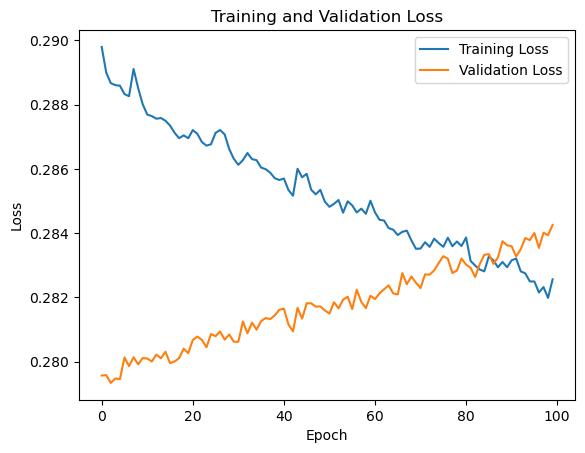

In [157]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [175]:
# Number of features in your dataset
n_features = len(X_train_no_inputation.columns) 


input_layer = Input(shape=(n_features,))
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dense(32, activation='relu')(encoder)


bottleneck = Dense(6, activation='relu')(encoder)  
encoder_model_noIpt = Model(inputs=input_layer, outputs=bottleneck)

# Define the decoder (mirror the encoder)
decoder = Dense(32, activation='relu')(bottleneck)
decoder = Dense(64, activation='relu')(decoder)

# Output layer
output_layer = Dense(n_features, activation='sigmoid')(decoder) 

# Define the autoencoder model
autoencoder_noIpt = Model(inputs=input_layer, outputs=output_layer)

# Compile the autoencoder
autoencoder_noIpt.compile(optimizer='adam', loss='mse')

In [176]:
history_noIpt =autoencoder_noIpt.fit(X_train_no_inputation, X_train_no_inputation,  # The target is the input data itself
                epochs=100,
                batch_size=16,
                shuffle=True,
                validation_data=(X_test_no_inputation, X_test_no_inputation))

Epoch 1/100
17/17 [==============================] - 2s 67ms/step - loss: 0.6154 - val_loss: 0.4562
Epoch 2/100
17/17 [==============================] - 0s 9ms/step - loss: 0.4007 - val_loss: 0.3292
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 0.3544 - val_loss: 0.3258
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.3533 - val_loss: 0.3238
Epoch 5/100
17/17 [==============================] - 0s 5ms/step - loss: 0.3513 - val_loss: 0.3229
Epoch 6/100
17/17 [==============================] - 0s 7ms/step - loss: 0.3502 - val_loss: 0.3215
Epoch 7/100
17/17 [==============================] - 0s 7ms/step - loss: 0.3492 - val_loss: 0.3199
Epoch 8/100
17/17 [==============================] - 0s 5ms/step - loss: 0.3491 - val_loss: 0.3207
Epoch 9/100
17/17 [==============================] - 0s 5ms/step - loss: 0.3488 - val_loss: 0.3206
Epoch 10/100
17/17 [==============================] - 0s 5ms/step - loss: 0.3485 - val_loss: 0.3192
Epoch 11

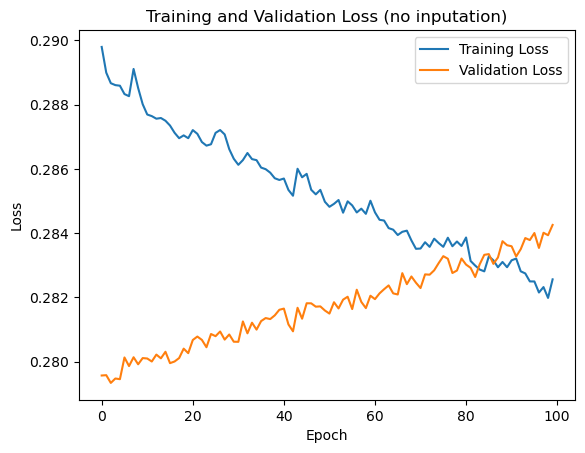

In [177]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (no inputation)')
plt.legend()
plt.show()

In [178]:
encoded_no_inputation = encoder_model_noIpt.predict(X_train_no_inputation)
encoded_no_inputation.shape

9/9 [==============================] - 0s 2ms/step


(257, 6)

In [ ]:
def map_years_to_group(value):
    years = value / 365
    if years <= 1:
        return 0
    elif 1 < years <= 3:
        return 1
    elif 3 < years <= 5:
        return 2
    elif 5 < years <= 10:
        return 3
    elif 10 < years <= 20:
        return 4
    else:  # years > 20 or alive which is nan in y
        return 5
y_train_no_inputation = y_train_no_inputation.apply(map_years_to_group)
y_train_no_inputation

In [179]:
from sklearn.decomposition import PCA

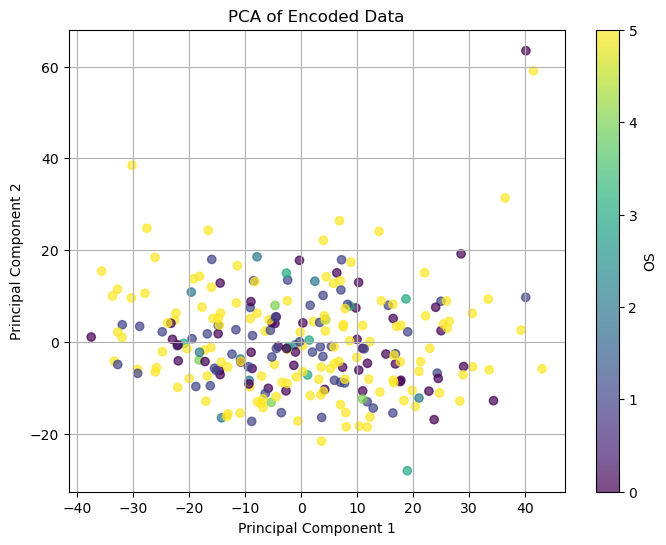

In [181]:
pca = PCA(n_components=2)  # Reduce to 2 dimensions
reduced_data = pca.fit_transform(encoded_no_inputation)

# The first and second PCA components will serve as your x and y axes
x = reduced_data[:, 0]
y = reduced_data[:, 1]
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, c=y_train_no_inputation, cmap='viridis', alpha=0.7)
plt.title('PCA of Encoded Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='OS')
plt.grid(True)
plt.show()

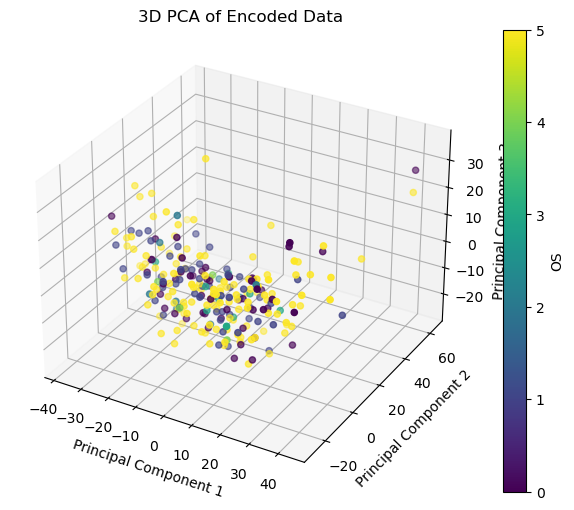

In [182]:
pca = PCA(n_components=3)  # Reduce to 2 dimensions
reduced_data = pca.fit_transform(encoded_no_inputation)

# The first and second PCA components will serve as your x and y axes
x = reduced_data[:, 0]
y = reduced_data[:, 1]
z = reduced_data[:, 2]
fig =plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=y_train_no_inputation, cmap='viridis', depthshade=True)
ax.set_title('3D PCA of Encoded Data')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(scatter, label='OS')
plt.show()


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.12      0.13        50
           1       0.20      0.26      0.23        53
           2       0.02      0.11      0.04         9
           3       0.00      0.00      0.00         9
           4       0.03      0.50      0.06         4
           5       0.56      0.14      0.22       132

    accuracy                           0.16       257
   macro avg       0.16      0.19      0.11       257
weighted avg       0.36      0.16      0.19       257



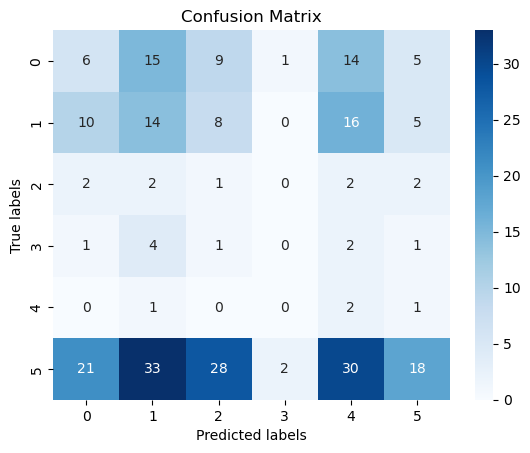

In [190]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Number of clusters - assuming you want as many as your known classes
num_clusters = 6
# Perform K-means clustering on the PCA output
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(reduced_data)  # Use your 2D or 3D PCA-reduced data here


print("Classification Report:")
print(classification_report(y_train_no_inputation, cluster_labels))
conf_mat = confusion_matrix(y_train_no_inputation, cluster_labels)

# Plotting the confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_clusters), yticklabels=np.unique(y_train_no_inputation))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Result not ideal at all, both shown by the prediction resutl and the pca result.
Try supervised:

3/3 [==============================] - 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.08      0.10        13
           1       0.12      0.05      0.07        19
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1
           5       0.54      0.83      0.65        46

    accuracy                           0.47        86
   macro avg       0.13      0.16      0.14        86
weighted avg       0.34      0.47      0.38        86



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


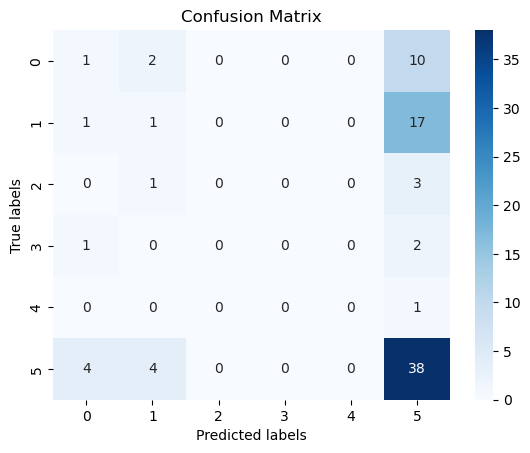

In [189]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

X_train = encoder_model_noIpt.predict(X_train_no_inputation)  # Your PCA-reduced features
y_train= y_train_no_inputation  # Your class labels
X_test = encoder_model_noIpt.predict(X_test_no_inputation)
y_test = y_test_no_inputation.apply(map_years_to_group)
labels = [0,1,2,3,4,5]
# Splitting the dataset into training and testing sets

# Initializing the Random Forest classifier with 100 trees
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fitting the classifier to the training data
clf.fit(X_train, y_train)

# Making predictions on the test set
y_pred = clf.predict(X_test)

# Evaluating the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


1. normalized by dividing the expression values by the sum of expression values of the analyzed genes for each sample
2. log2 transformed
3. z-scores were calculated
4. using Spearman distance and Ward criterion Cluster analyses
5. plot heatmaps using the z-score values matrix for color intensities.
6. Cox regression analyses using Kaplan–Meier curves to compare the three highest hierarchical sample groups on each heatmap
7. Cox regression multivariate was used to calculate the combined effect of HPV status and heatmap groups (Survival package in R)


https://docs.gdc.cancer.gov/Data/Bioinformatics_Pipelines/Expression_mRNA_Pipeline/
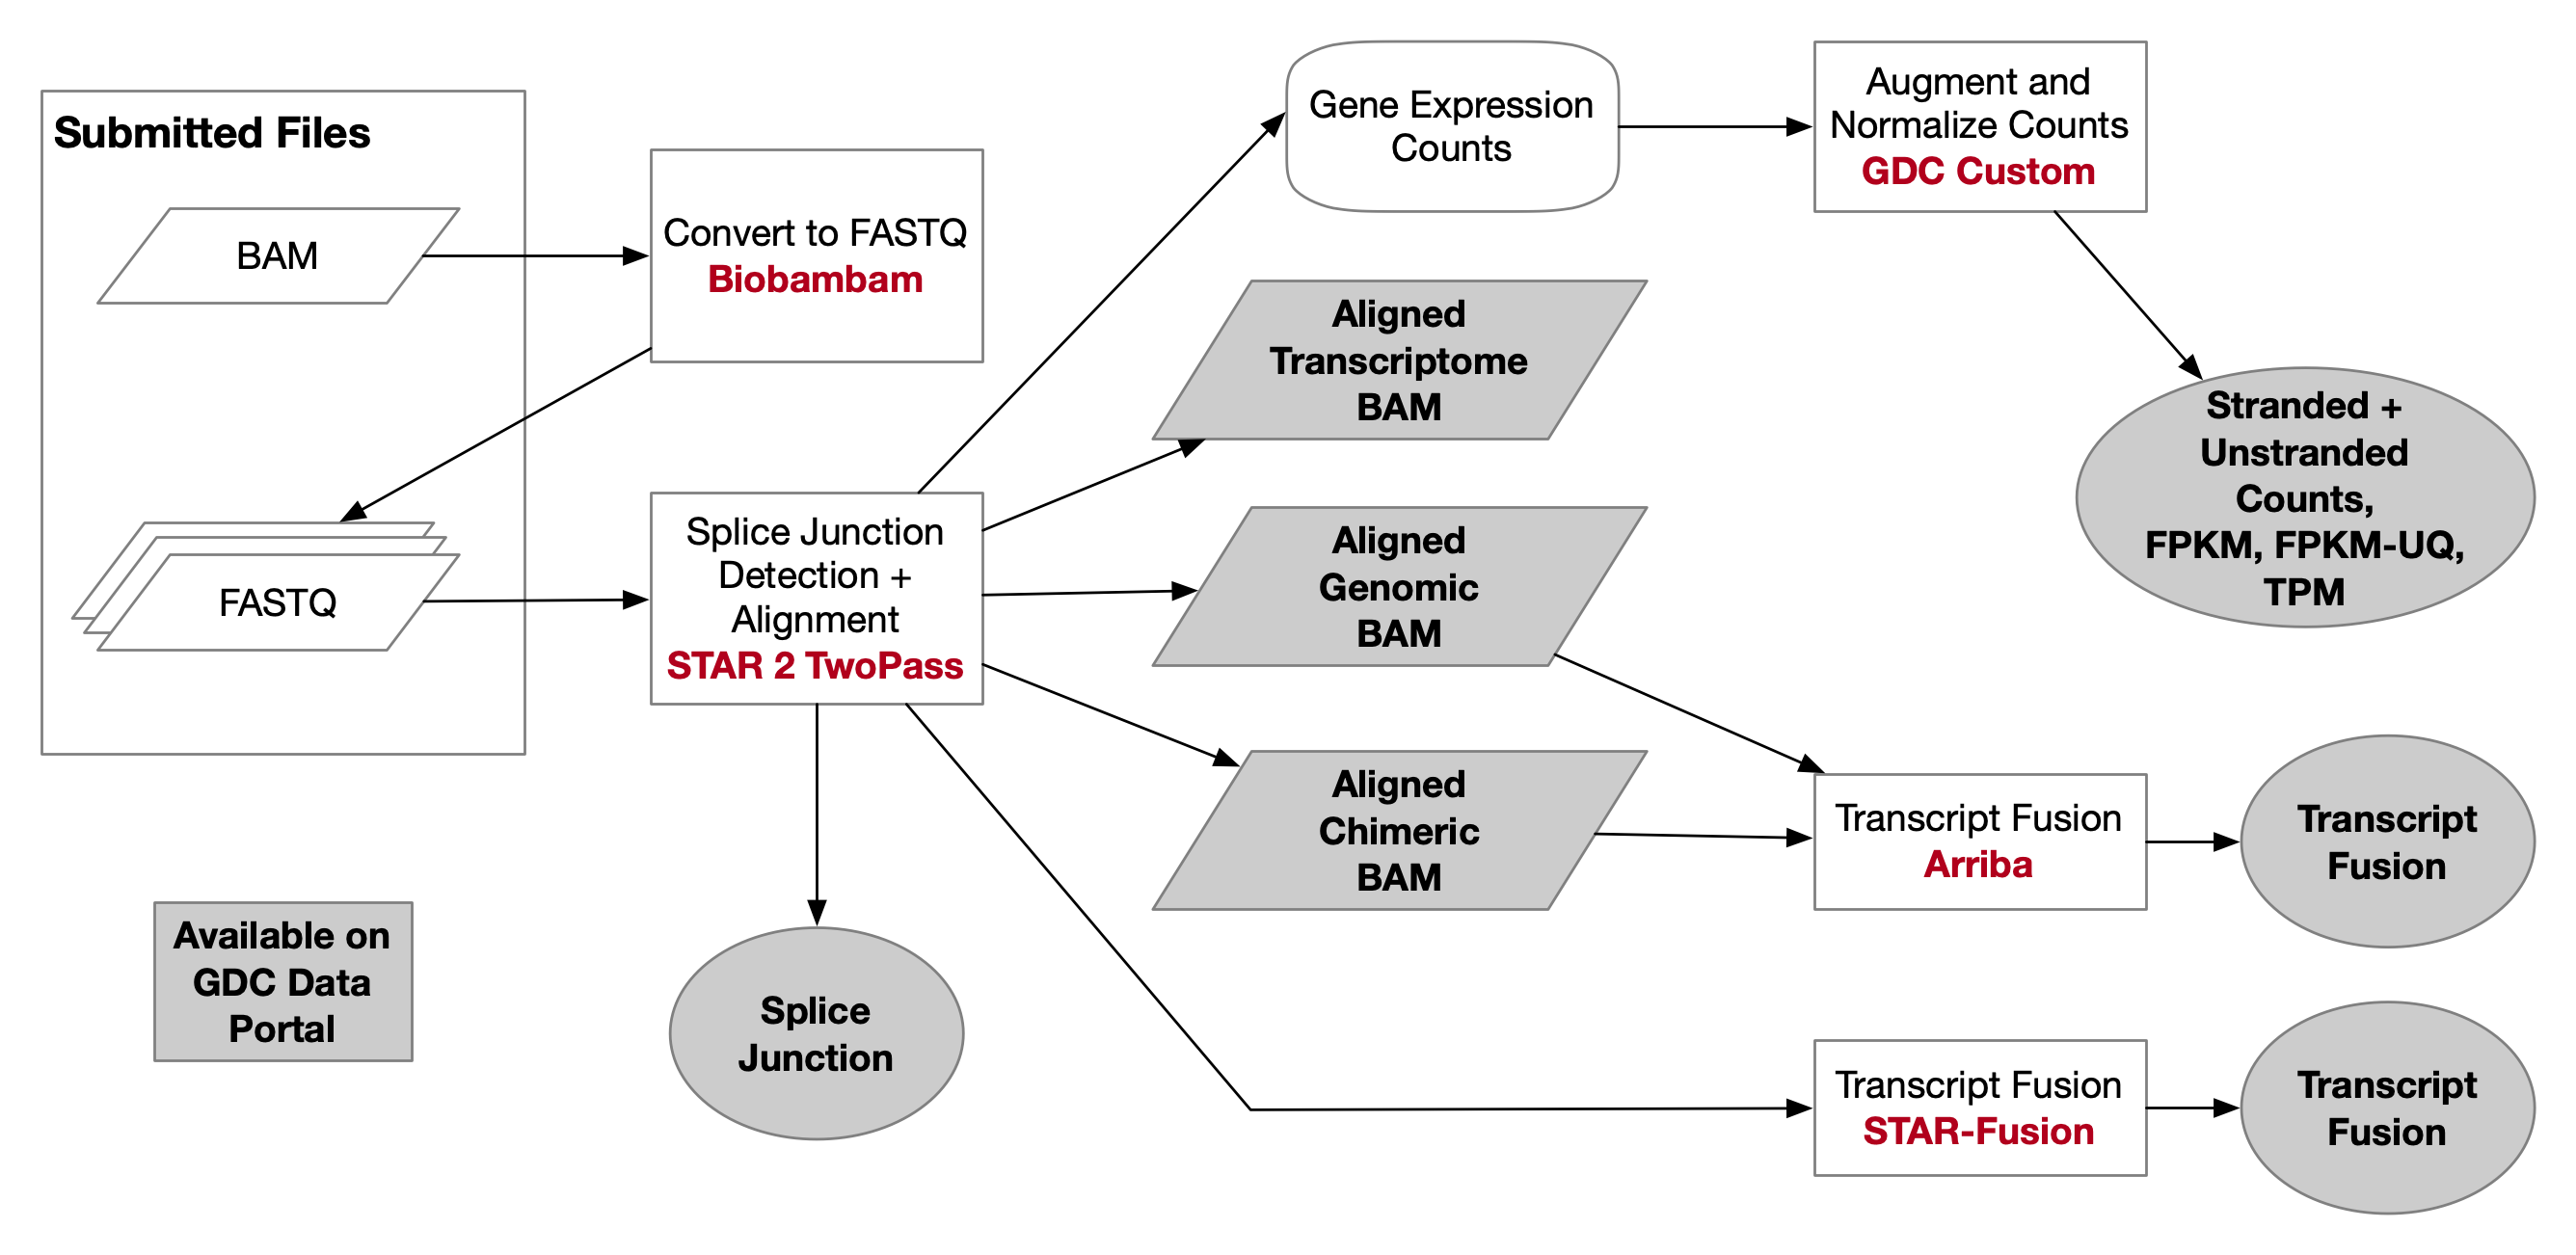
| unstranded | stranded_first |  stranded_second | tpm_unstranded | fpkm_unstranded | fpkm_uq_unstranded |

To deduce the hypoxia status, an algorithm of t-distributed Stochastic Neighbor Embedding (t-SNE) was applied [19]. t-SNE, a nonparametric, unsupervised method, can divide or condense patients into several distinct clusters, based on given signatures or hallmarks. The hallmark gene sets of hypoxia including 200 genes, were downloaded from the Molecular Signatures Database (MSigDB version 6.0). Further, expression changes of target genes involved in HIF-1 signaling pathway were analyzed between the hypoxiahigh and hypoxialow groups to explore their association with hypoxia. These targets were retrieved from the Kyoto Encyclopedia of Genes and Genomes (KEGG) database (https://www.kegg.jp/; ID:04066), including 15 genes involved in “Increase oxygen delivery” and 11 genes related to “Reduce oxygen consumption”. 
The limma algorithm was used to identify differentially expressed genes (DEGs) between the two groups [20]. Genes with a false discovery rate (FDR) adjusted p-value < 0.0001 and an absolute value of log2 (fold change) > 1 were considered as hypoxia-related DEGs.
limma algorithm
https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-020-02366-0
https://academic.oup.com/bib/article/22/6/bbab173/6273240?login=true

The predefined gene sets included in our research were acquired from the Molecular Signatures Database (MSigDB; https://www.gsea-msigdb.org/gsea/msigdb/index.jsp) (44). We used the terms “lactic” and “hypoxia” as the search keywords in the MSigDB database.  After deleting duplicates, 284 LMRGs and 493 HRGs were identified for subsequent analysis [Table S2].
We analyzed differentially expressed genes (DEGs) using the R package “edgeR” in R (| log2 fold change [FC]|>1 and P < 0.05). We then identified differentially expressed LMRGs (DELMRGs) and HRGs (DEHRGs) by intersecting DEGs with LMRGs and HRGs
https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2022.998140/full

MSigDB
Weighted gene co-expression network analysis (WGCNA) was used to construct a scale-free co-expression network using the R package 'WGCNA' and to identify a gene module which is mostly correlated with hypoxia [38]. 
https://www.thno.org/v11p5061.htm